In [1]:
from xgboost import XGBRegressor, XGBRFRegressor
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.ensemble import VotingRegressor
import numpy as np
import pandas as pd
import tensorflow as tf

from imbd.trainers import ModelTrainer
from imbd.data import DataLoader
from imbd.preprocessors import DataPreprocessor
from imbd.models import KerasModel

In [2]:
loader = DataLoader()
prepro = DataPreprocessor()


In [3]:
# initialization
loader = DataLoader()
preprocessor = DataPreprocessor()
df = loader.build()

# get feature & label
train_features = df.drop(loader.labels, axis=1)
train_labels = df[loader.labels]

In [4]:
train_features.isna().sum().sort_values(ascending=False).head(10)

Input_C_083     88
Input_C_091     88
Input_C_090     88
Input_C_089     88
Input_C_088     88
Input_C_087     88
Input_C_086     88
Input_C_085     88
Input_C_084     88
Input_A5_011     0
dtype: int64

In [5]:
# base_model = MultiOutputRegressor(XGBRegressor())
# base_model = MultiOutputRegressor(VotingRegressor([('xgb', XGBRegressor()), ('xgb_rf', XGBRFRegressor())]))
order = [0, 2, 5, 7, 13, 14, 16, 17] + [1, 3, 4, 6, 8, 9, 11, 12, 15, 18, 19] + [10]
base_model = RegressorChain(VotingRegressor([('xgb', XGBRegressor()), ('xgb_rf', XGBRFRegressor())]), order=order)
# base_model = RegressorChain(XGBRFRegressor(), order=order)

# base_nn_model = KerasRegressor(build_fn=classifier, epochs=100)
base_nn_model = KerasModel()

In [6]:

param_grid = {
    "prepro__variance_selector__threshold": [0.0, 0.01],
    # "voting__estimator__xgb__subsample": [1, 0.5],
    # "voting__estimator__xgb__max_depth": [2, 6],
    # "voting__estimator__xgb_rf__max_depth": [2, 6],
    # "voting__estimator__xgb_rf__subsample": [1, 0.5],
    "voting__base_estimator__weights": [[0.4, 0.6]],
    "voting__base_estimator__xgb__n_estimators": [1000],
    "voting__base_estimator__xgb_rf__n_estimators": [1000],
}

In [7]:
# build pipeline
steps = [('prepro', preprocessor), ('voting', base_model)]
pipe = Pipeline(steps=steps)

In [8]:
pipe.get_params()['voting']

RegressorChain(base_estimator=VotingRegressor(estimators=[('xgb',
                                                           XGBRegressor(base_score=None,
                                                                        booster=None,
                                                                        colsample_bylevel=None,
                                                                        colsample_bynode=None,
                                                                        colsample_bytree=None,
                                                                        gamma=None,
                                                                        gpu_id=None,
                                                                        importance_type='gain',
                                                                        interaction_constraints=None,
                                                                        learning_rate=None,
              

In [9]:
# training
trainer = ModelTrainer(pipe=pipe, param_grid=param_grid, verbose=2)
# fitted = trainer.fit(train_features, train_labels)
fitted = trainer.fit(train_features, train_labels)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] prepro__variance_selector__threshold=0.0, voting__base_estimator__weights=[0.4, 0.6], voting__base_estimator__xgb__n_estimators=1000, voting__base_estimator__xgb_rf__n_estimators=1000 
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV]  prepro__variance_selector__threshold=0.0, voting__base_estimator__weights=[0.4, 0.6], voting__base_estimator__xgb__n_estimators=1000, voting__base_estimator__xgb_rf__n_estimators=1000, total= 1.1min
[CV] prepro__variance_selector__threshold=0.0, voting__base_estimator__weights=[0.4, 0.6], voting__base_estimator__xgb__n_estimators=1000, voting__base_estimator__xgb_rf__n_estimators=1000 
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s
[CV]  prepro__variance_selector__threshold=0.0, voting__base_estimator__weights=[0.4, 0.6], voting__base_estimator__xgb__n_estimators=1000, voting__base_estimator__xgb_rf__n_estimators=1000, tota

In [10]:
fitted.best_score_

-0.12960641906809192

In [11]:
pd.DataFrame(fitted.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_prepro__variance_selector__threshold,param_voting__base_estimator__weights,param_voting__base_estimator__xgb__n_estimators,param_voting__base_estimator__xgb_rf__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,60.547965,6.195506,1.019513,0.374467,0,"[0.4, 0.6]",1000,1000,"{'prepro__variance_selector__threshold': 0.0, ...",-0.142027,-0.164869,-0.081923,-0.129606,0.034983,1,-0.021839,-0.01898,-0.032173,-0.024331,0.005667
1,0.011423,0.001527,0.000000,0.000000,0.01,"[0.4, 0.6]",1000,1000,"{'prepro__variance_selector__threshold': 0.01,...",NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN


In [12]:
pred = fitted.predict(train_features)
pred = pd.DataFrame(pred, columns=train_labels.columns)

res = np.abs(pred - train_labels)
res = res.rename(mapper=lambda x: x + "_diff", axis=1)
res['mean'] = np.mean(res, axis=1)
res['label'] = pd.cut(res['mean'].astype('category'), bins=3, labels=['0', '1', '2'])
res['label'] = res['label'].astype(int)

In [13]:
res

,Input_A6_024_diff,Input_A3_016_diff,Input_C_013_diff,Input_A2_016_diff,Input_A3_017_diff,Input_C_050_diff,Input_A6_001_diff,Input_C_096_diff,Input_A3_018_diff,Input_A6_019_diff,...,Input_A3_015_diff,Input_C_046_diff,Input_C_049_diff,Input_A2_024_diff,Input_C_058_diff,Input_C_057_diff,Input_A3_013_diff,Input_A2_017_diff,mean,label
0,0.000252,0.003659,0.000161,0.001467,0.000497,0.001065,0.000495,0.003044,0.004731,0.004561,...,0.010071,0.000060,0.000115,0.000038,0.001222,0.000778,0.000117,0.003424,0.004248,0
1,0.000008,0.000775,0.000515,0.001839,0.004059,0.000317,0.000006,0.004883,0.003695,0.000382,...,0.006829,0.000088,0.000024,0.000044,0.000525,0.000774,0.000151,0.000954,0.003293,0
2,0.000010,0.001387,0.000301,0.001787,0.003094,0.000365,0.000006,0.001076,0.002651,0.002333,...,0.006875,0.000049,0.000094,0.000066,0.000196,0.001327,0.000017,0.002247,0.002124,0
3,0.000104,0.004211,0.000479,0.005528,0.006104,0.000311,0.000111,0.002275,0.006875,0.004256,...,0.000061,0.000453,0.000376,0.000132,0.000081,0.000487,0.000544,0.002272,0.002923,0
4,0.000239,0.003708,0.000332,0.003231,0.002416,0.000570,0.000006,0.000192,0.001882,0.003463,...,0.005129,0.000086,0.000071,0.000121,0.000487,0.001533,0.001418,0.002158,0.004548,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,0.000066,0.000409,0.000167,0.002277,0.000074,0.000129,0.000006,0.000430,0.004215,0.000325,...,0.006707,0.000020,0.000082,0.001146,0.000125,0.000018,0.000329,0.000636,0.002078,0
335,0.001009,0.005652,0.000114,0.001106,0.001081,0.000033,0.000039,0.000486,0.004195,0.001723,...,0.007935,0.000431,0.000325,0.000384,0.000028,0.000440,0.000654,0.001583,0.003343,0
336,0.000090,0.000645,0.000167,0.000991,0.004217,0.000112,0.000006,0.000654,0.000489,0.001094,...,0.000117,0.000567,0.000014,0.000003,0.000196,0.000537,0.001131,0.003535,0.002025,0
337,0.000017,0.000772,0.000226,0.002729,0.004975,0.000193,0.000006,0.000423,0.004599,0.003913,...,0.005004,0.000124,0.000393,0.000015,0.000042,0.000209,0.000155,0.000711,0.002906,0


In [14]:
import plotly.express as px

In [15]:
res.filter(regex='Input_A[0-9]*_[0-9]+').columns

Index(['Input_A6_024_diff', 'Input_A3_016_diff', 'Input_A2_016_diff',
       'Input_A3_017_diff', 'Input_A6_001_diff', 'Input_A3_018_diff',
       'Input_A6_019_diff', 'Input_A1_020_diff', 'Input_A6_011_diff',
       'Input_A3_015_diff', 'Input_A2_024_diff', 'Input_A3_013_diff',
       'Input_A2_017_diff'],
      dtype='object')

In [16]:
train_labels.columns

Index(['Input_A6_024', 'Input_A3_016', 'Input_C_013', 'Input_A2_016',
       'Input_A3_017', 'Input_C_050', 'Input_A6_001', 'Input_C_096',
       'Input_A3_018', 'Input_A6_019', 'Input_A1_020', 'Input_A6_011',
       'Input_A3_015', 'Input_C_046', 'Input_C_049', 'Input_A2_024',
       'Input_C_058', 'Input_C_057', 'Input_A3_013', 'Input_A2_017'],
      dtype='object')

In [17]:
feature_cols = list(train_features.filter(regex='Input_A[0-9]_020').columns)
diff_cols = list(res.filter(regex='Input_A1_[0-9]+_diff').columns[:5])

fig = px.parallel_coordinates(pd.concat([train_features, res], axis=1), feature_cols + diff_cols + ['label'] , color='label')
fig.update_layout(width=1600, height=800)
fig.show()

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

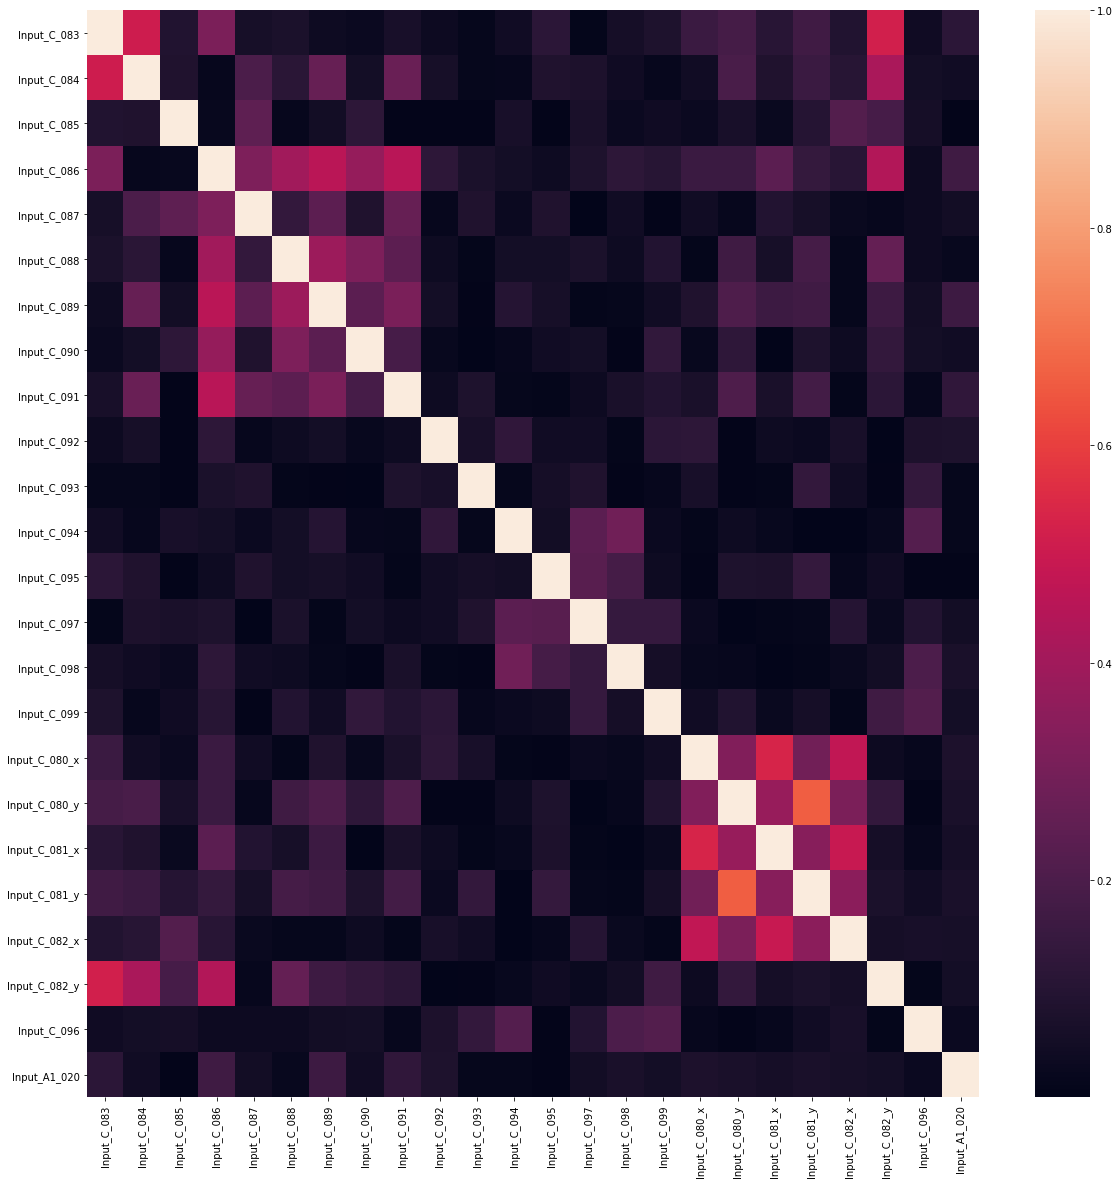

In [19]:
fig_, ax = plt.subplots(figsize=(20, 20))
test = pd.concat([train_features,train_labels], axis=1)
sns.heatmap(np.abs(test.filter(regex='(massive*|Input_C_0[8-9][0-9]|Input_A1_020)').corr()))

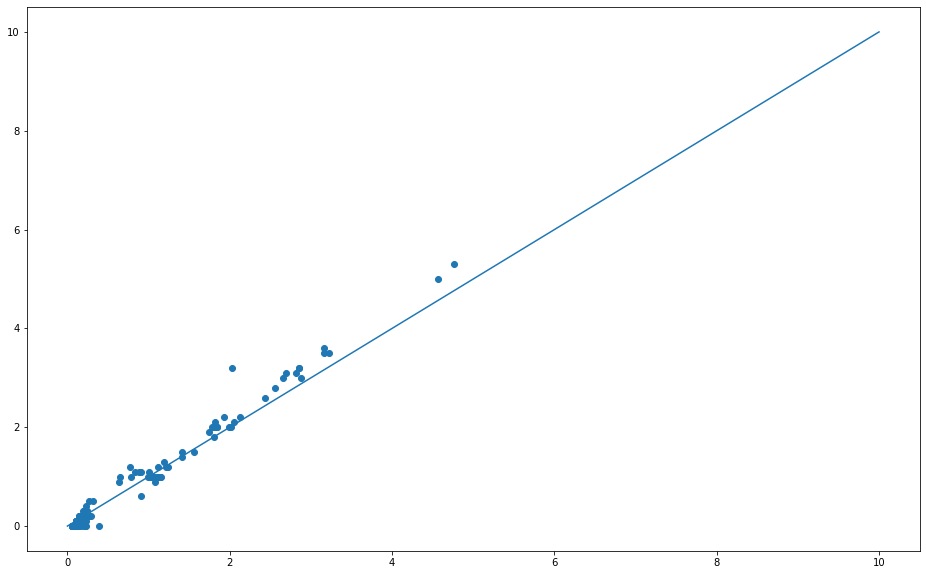

In [20]:
fig, ax = plt.subplots(figsize=(16, 10))
test = pd.concat([pred['Input_A1_020'], train_labels['Input_A1_020']], axis=1)

plt.scatter(test.values[:,0], test.values[:, 1])
x = np.linspace(0, 10, 10)
plt.plot(x, x)


In [21]:
np.sqrt(np.mean((test.iloc[:, 0] - test.iloc[:, 1]) ** 2))

0.1257048128633158

In [22]:
fitted.best_score_

-0.12960641906809192

In [23]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE, LocallyLinearEmbedding
from sklearn.decomposition import PCA

In [24]:
km = KMeans(3)
tsne = PCA()

In [25]:
cl = km.fit_predict(train_features.dropna().filter(regex='Input_A[0-9]_020'))

In [26]:
cl

array([1, 1, 1, 2, 1, 1, 1, 1, 2, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 2, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [27]:
test = tsne.fit_transform(train_features.dropna().filter(regex='Input_A[0-9]_020'))

In [28]:
import plotly.graph_objects as go

go.Figure(data=go.Scatter(x=test[:, 0], y=test[:, 1], mode='markers', marker_color=cl, marker_size=train_labels.dropna()['Input_A1_020']*5, text=train_labels.dropna()['Input_A1_020']))